In [4]:
import numpy as np
import pandas as pd
import models.cv
from collections import defaultdict
import os

# Analyze sGO prevelance

In [5]:
d = np.load("../generated-data/features/ppc_yeast_common_sgo.npz")
F = d['F'].astype(bool)
terms = d['feature_labels']

df = pd.read_csv("../generated-data/task_yeast_smf_30")
bins = np.array(df['bin'])
ids = df['id']

counts_by_term = defaultdict(lambda: [0,0,0])

for i, gene_id in enumerate(ids):
    thebin = bins[i]

    gene_terms = [gt for gt in terms[F[gene_id,:]]]
        
    for gt in gene_terms:
        counts_by_term[gt][int(thebin)] += 1

#     if len(gene_terms) == 0:
#         counts_by_term['No Term'][int(thebin)] += 1
    
rows = []
for term in counts_by_term:
    cnts = np.array(counts_by_term[term])
    normed_cnts = cnts / np.sum(cnts)

    rows.append({
            "term" : term,
            "lethal" : cnts[0],
            "sick" : cnts[1],
            "healthy" : cnts[2],
            "lethal_p" : normed_cnts[0],
            "sick_p" : normed_cnts[1],
            "healthy_p" : normed_cnts[2],
            "total" : np.sum(cnts),
            "diff" : (np.max(normed_cnts) - np.min(normed_cnts))
    })


df = pd.DataFrame(rows).set_index('term')

In [18]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# get the go terms sorted by most prevelant in healthy class
df_healthy = df.sort_values('healthy_p', ascending=False)
df_lethal = df.sort_values('lethal_p', ascending=False)
df_random = df.sample(frac=1)
print(df_random.shape)
# specify target df
target_df = df_random
output_path = "../results/yeast_smf_go_exploration/mn_random_first_%d"

# eliminate top 20%
top_p = [0.2, 0.4, 0.6, 0.8]

print(output_path)

(45, 8)
../results/yeast_smf_go_exploration/mn_random_first_%d


In [19]:
for p in top_p:
    n = int(p * target_df.shape[0])
    terms = list(target_df.index[n:])
    print("Eliminating top %d" % n)
    
    spec = [
                        {
                            "name" : "topology",
                            "path" : "../generated-data/features/ppc_yeast_topology.npz",
                            "selected_features" : ["lid"]
                        },
                        {
                            "name" : "redundancy",
                            "selected_features" : ["pident"],
                            "path" : "../generated-data/features/ppc_yeast_redundancy.npz"
                        },
                        {
                            "name" : "go",
                            "path" : "../generated-data/features/ppc_yeast_common_sgo.npz",
                            "selected_features" : terms
                        }
                   ]
    if p == 1:
        spec = spec[:-1]
    
    models.cv.main("models.smf_ordinal", 
                   "cfgs/models/yeast_smf_orm.json", 
                   output_path % n, 
                   type="mn", 
                   spec=spec,
                   num_processes=20)

Eliminating top 9
{'spec': [{'name': 'topology', 'path': '../generated-data/features/ppc_yeast_topology.npz', 'selected_features': ['lid']}, {'name': 'redundancy', 'selected_features': ['pident'], 'path': '../generated-data/features/ppc_yeast_redundancy.npz'}, {'name': 'go', 'path': '../generated-data/features/ppc_yeast_common_sgo.npz', 'selected_features': ['GO:0016491', 'GO:0008289', 'GO:0051604', 'GO:0003677', 'GO:0016798', 'GO:0006629', 'GO:0005975', 'GO:0005794', 'GO:0003924', 'GO:0030234', 'GO:0016757', 'GO:0006520', 'GO:0005773', 'GO:0019899', 'GO:0008168', 'GO:0051082', 'GO:0006091', 'GO:0000902', 'GO:0007005', 'GO:0016874', 'GO:0003735', 'GO:0008134', 'GO:0005886', 'GO:0008233', 'GO:0051186', 'GO:0008092', 'GO:0005777', 'GO:0005730', 'GO:0005856', 'GO:0022857', 'GO:0016791', 'GO:0005694', 'GO:0016829', 'GO:0016779', 'GO:0042393', 'GO:0005634']}], 'scramble': False, 'optimizer': 'nadam', 'epochs': 10000, 'verbose': True, 'patience': 50, 'balanced_loss': True, 'batch_size_p': 1,

## Plot analysis

In [61]:
import matplotlib.pyplot as plt
import utils.eval_funcs as eval_funcs 
from matplotlib.ticker import FormatStrFormatter

In [57]:

def extract_curve(target_df, base_path, ps):
    
    baccs = []
    for p in ps:
        n = int(p * target_df.shape[0])
        
        path = base_path % n
        
        if p == 0:
            path = "../results/yeast_smf_go_exploration/mn"
        
        files = eval_funcs.get_files(path)
        cv_baccs = []
        for file in files:
            d = np.load(file, allow_pickle=True)

            r = d['r'].item()
            
            cv_baccs.append(r['bacc'])
        
        baccs.append((np.mean(cv_baccs), np.std(cv_baccs, ddof=1) / np.sqrt(len(cv_baccs))))
        
    return np.array(baccs)

print(extract_curve(df_healthy, "../results/yeast_smf_go_exploration/mn_healthy_first_%d", [0, 0.2, 0.4, 0.6, 0.8, 1]))
print(extract_curve(df_lethal, "../results/yeast_smf_go_exploration/mn_lethal_first_%d", [0, 0.2, 0.4, 0.6, 0.8, 1]))
print(extract_curve(df_random, "../results/yeast_smf_go_exploration/mn_random_first_%d", [0, 0.2, 0.4, 0.6, 0.8, 1]))

[[0.60367921 0.00264504]
 [0.59556458 0.00248899]
 [0.59900897 0.00289859]
 [0.58958119 0.00244956]
 [0.58581502 0.00260696]
 [0.53144942 0.0023462 ]]
[[0.60367921 0.00264504]
 [0.59404669 0.00272249]
 [0.59339459 0.0025682 ]
 [0.5898114  0.00267589]
 [0.5702401  0.00253504]
 [0.53144942 0.0023462 ]]
[[0.60367921 0.00264504]
 [0.60057105 0.00223922]
 [0.59611378 0.00232875]
 [0.59235195 0.00236613]
 [0.55175356 0.0025729 ]
 [0.53144942 0.0023462 ]]


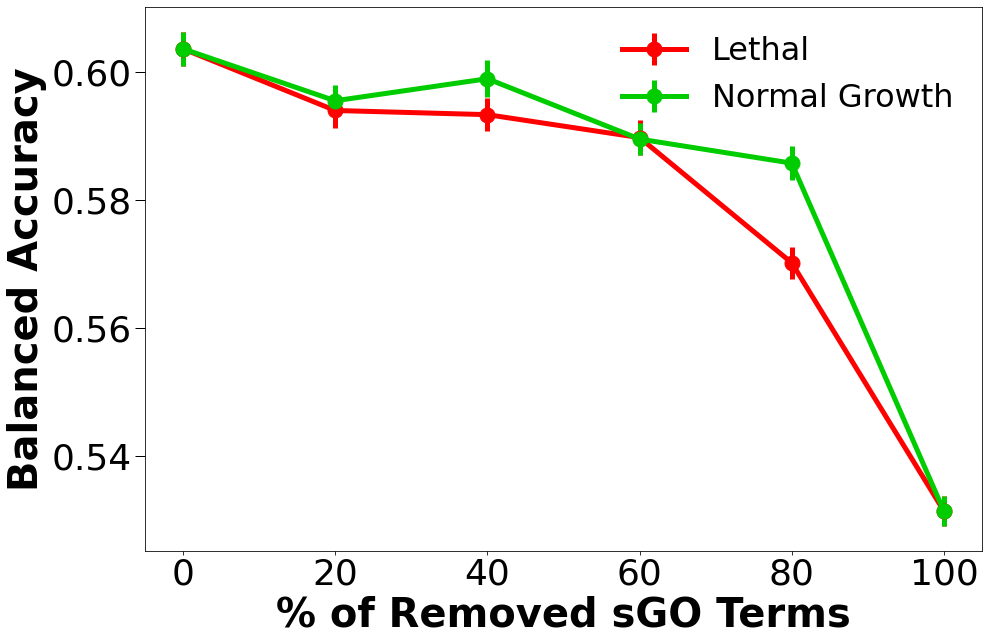

In [83]:
curves = [
    ('Lethal', extract_curve(df_lethal, "../results/yeast_smf_go_exploration/mn_lethal_first_%d", [0, 0.2, 0.4, 0.6, 0.8, 1])),
    ('Normal Growth', extract_curve(df_healthy, "../results/yeast_smf_go_exploration/mn_healthy_first_%d", [0, 0.2, 0.4, 0.6, 0.8, 1])),
    
    #('Random First', extract_curve(df_lethal, "../results/yeast_smf_go_exploration/mn_random_first_%d", [0, 0.2, 0.4, 0.6, 0.8, 1])),
]

plot_cfg = {
    "tick_label_size" : 36,
    "xlabel_size" : 40,
    "ylabel_size" : 40,
    "border_size" : 10,
    "bar_border_size" : 2.5,
    "bar_label_size" : 65,
    "stars_label_size" : 48,
    "annot_size" : 72,
    "max_cm_classes" : 4,
    "max_bars" : 5,
    "legend_font_size" : 60
}

colors = ['#FF0000', '#00CC00']
f, ax = plt.subplots(1, 1, figsize=(15, 10))
i = 0
for label, curve in curves:
    mean_bacc = curve[:,0]
    std_bacc = curve[:,1]
    ax.errorbar(np.array([0, 0.2, 0.4, 0.6, 0.8, 1]) * 100, mean_bacc, color=colors[i], yerr=std_bacc, marker='o', linewidth=5, markersize=15, label=label)
    i+=1
ax.yaxis.set_tick_params(labelsize=plot_cfg["tick_label_size"])
ax.xaxis.set_tick_params(labelsize=plot_cfg["tick_label_size"])
ax.set_xlabel('% of Removed sGO Terms', fontsize=plot_cfg['xlabel_size'], weight='bold')
ax.set_ylabel('Balanced Accuracy', fontsize=plot_cfg["ylabel_size"], weight='bold')
ax.yaxis.set_tick_params(length=10, width=1, which='both')
ax.yaxis.set_major_formatter(FormatStrFormatter('%0.2f'))
ax.legend(fontsize=32, frameon=False, loc='upper right')
#plt.setp(ax.spines.values(), linewidth=plot_cfg["border_size"], color='black')
plt.savefig('../tmp/smf_sgo_elimination.png', bbox_inches='tight', dpi=300)